In [2]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import trange
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

pd.options.display.float_format = '{:.2f}'.format
gc.enable()

In [2]:
ts = pd.read_csv("../input/btcusdt/binance_btcusdt_kline_1m.csv")
ts["t"] = pd.to_datetime(ts["t"], unit="ms")
ts.head()

,t,o,h,l,c,v
0,2020-12-31 16:00:00,28782.01,28821.85,28763.94,28811.85,95.84
1,2020-12-31 16:01:00,28812.64,28822.59,28714.29,28726.62,58.52
2,2020-12-31 16:02:00,28728.28,28744.76,28684.69,28693.37,75.04
3,2020-12-31 16:03:00,28693.37,28715.15,28682.09,28690.29,37.13
4,2020-12-31 16:04:00,28690.29,28734.70,28680.00,28715.11,38.41


<AxesSubplot:xlabel='t'>

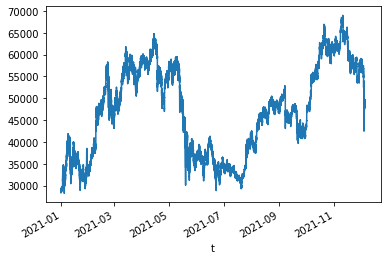

In [4]:
plot_ts = pd.Series(data=ts["c"].values, index=ts["t"])
plot_ts.plot()

<AxesSubplot:xlabel='t'>

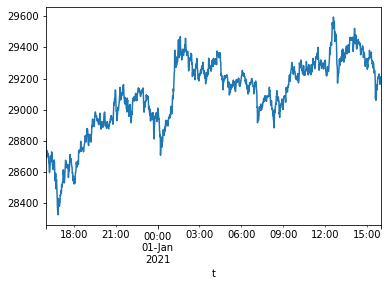

In [5]:
plot_ts.iloc[:60*24].plot()

In [3]:
# assume as categorical
ts["day"] = ts["t"].dt.dayofyear
ts["month"] = ts["t"].dt.month
ts["year"] = ts["t"].dt.year
ts["hour"] = ts["t"].dt.hour

cat_cols = ["day", "month", "year", "hour"]

In [7]:
for col in cat_cols:
    print(col, ":", ts[col].nunique())

day : 340
month : 12
year : 2
hour : 24


In [4]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X, y = [], []
    start += window
    if end is None:
        end = len(dataset) - horizon
    for i in trange(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicesy = range(i+1, i+horizon+1)
        y.append(target[indicesy])
    return np.array(X), np.array(y)

In [5]:
X, y = ts.drop(["t"] + cat_cols, axis=1), ts["c"]  # DO NOT DROP "c" as we are predicting next 10 values of "c" based on previous "history_window" values of "c" and exogenious predictors
# we can also try to predict next "c" values with only exogenious variables ("o", "h", "days", etc.)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X[["o", "h", "l", "v"]] = scaler_x.fit_transform(X[["o", "h", "l", "v"]])  # scale exogenious
X["c"] = scaler_y.fit_transform(X["c"].values.reshape(-1,1))  # scale "c"
x_scaled = X[["o", "h", "l", "v", "c"]].values  # leakage?

y_scaled = scaler_y.transform(y[:, np.newaxis])  # scale target with same min and max as "c"

In [10]:
history_window = 60
horizon = 10
train_split = 345000
batch_size = 32
buffer_size = len(x_scaled)

In [7]:
x_train, y_train = custom_ts_multi_data_prep(x_scaled, y_scaled, 0, train_split, history_window, horizon)
x_test, y_test = custom_ts_multi_data_prep(x_scaled, y_scaled, train_split, None, history_window, horizon)

100%|██████████| 142097/142097 [00:02<00:00, 62110.80it/s]


In [8]:
x_train_hour = ts["hour"].iloc[history_window:train_split].values.reshape(-1,1)
x_test_hour = ts["hour"].iloc[train_split+history_window:-horizon].values.reshape(-1,1)

x_train_day = ts["day"].iloc[history_window:train_split].values.reshape(-1,1)
x_test_day = ts["day"].iloc[train_split+history_window:-horizon].values.reshape(-1,1)

In [9]:
train_data = tf.data.Dataset.from_tensor_slices(({"hour": x_train_hour, "days": x_train_day, "number": x_train}, y_train)).cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices(({"hour": x_test_hour, "days": x_test_day, "number": x_test}, y_test)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

2022-10-30 21:16:19.472322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 21:16:19.572328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 21:16:19.573271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 21:16:19.575711: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Baseline**

In [24]:
# LSTM models: single, double, autoencoder, bidirectional

hour_inputs = layers.Input(shape=(1,), name="hour")
days_inputs = layers.Input(shape=(1,), name="days")
num_inputs = layers.Input(shape=x_train.shape[-2:], name="number")

x_hour = layers.Embedding(24, 2)(hour_inputs)
x_days = layers.Embedding(367, 3)(days_inputs)

x_hour = layers.Flatten()(x_hour)
x_days = layers.Flatten()(x_days)

x = layers.LSTM(64, return_sequences=False)(num_inputs)
x = layers.Concatenate(axis=-1)([x, x_hour, x_days])
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(horizon)(x)

model = tf.keras.Model(inputs=[hour_inputs, days_inputs, num_inputs], outputs=x, name="lstm_model")
model.summary()

Model: "lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hour (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
days (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
number (InputLayer)             [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 2)         48          hour[0][0]                       
_________________________________________________________________________________________

In [10]:
def plot_predictions(epoch=None, logs=None):
    plt.figure(figsize=(10,4))
    y_pred = model.predict({"hour": x_test_hour, "days": x_test_day, "number": x_test}, verbose=0)
    score = r2_score(y_test.squeeze(), y_pred)
    y_pred_1 = scaler_y.inverse_transform(y_pred[:,0].reshape(-1,1))
    y_pred_2 = scaler_y.inverse_transform(y_pred[:,-1].reshape(-1,1))
    y_true = scaler_y.inverse_transform(y_test.squeeze()[:,0].reshape(-1,1))
    plt.title(f"$R^2$ score: {score:.4f}")
    plt.plot(y_true, label="gt")
    plt.plot(y_pred_1, label="preds on step 1")
    plt.plot(y_pred_2, label="preds on last step")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Epoch 1/20
10780/10780 [==============================] - 87s 8ms/step - loss: 3.3600e-04 - val_loss: 0.0393


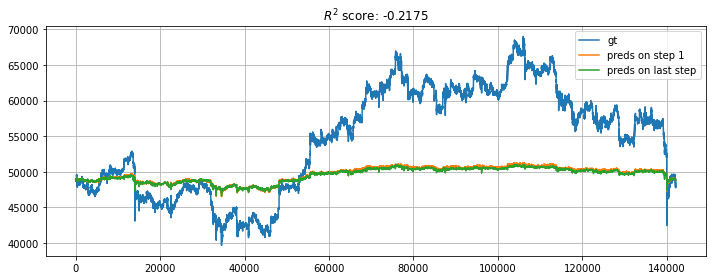

Epoch 2/20
10780/10780 [==============================] - 77s 7ms/step - loss: 2.9199e-04 - val_loss: 0.0331


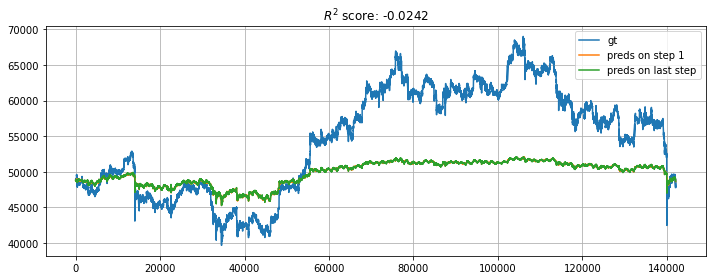

Epoch 3/20
10780/10780 [==============================] - 77s 7ms/step - loss: 2.7688e-04 - val_loss: 0.0449


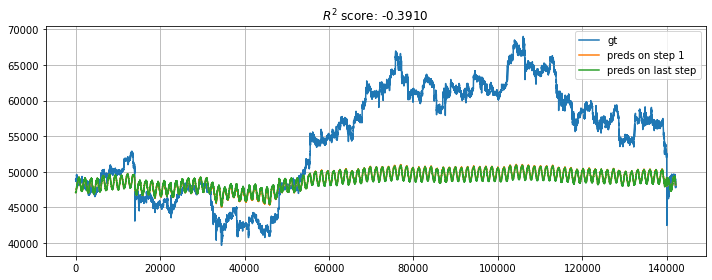

Epoch 4/20
10780/10780 [==============================] - 76s 7ms/step - loss: 3.5452e-04 - val_loss: 0.0384


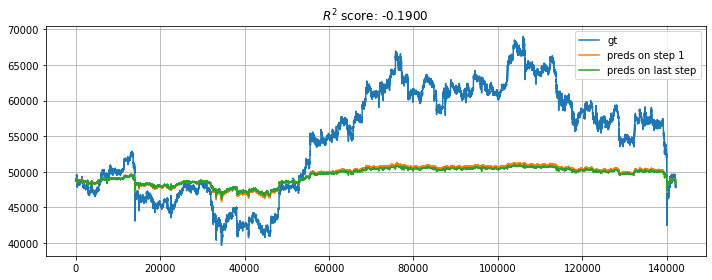

Epoch 5/20
10780/10780 [==============================] - 77s 7ms/step - loss: 2.6990e-04 - val_loss: 0.0353


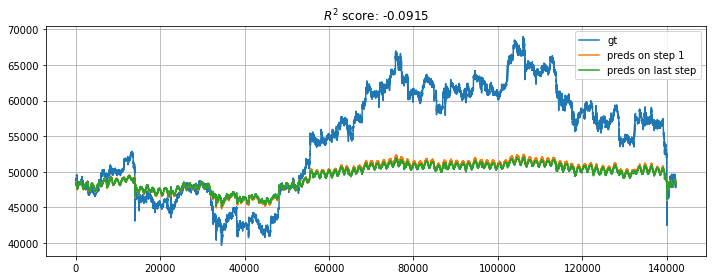

Epoch 6/20
10780/10780 [==============================] - 85s 8ms/step - loss: 4.6996e-04 - val_loss: 0.0067


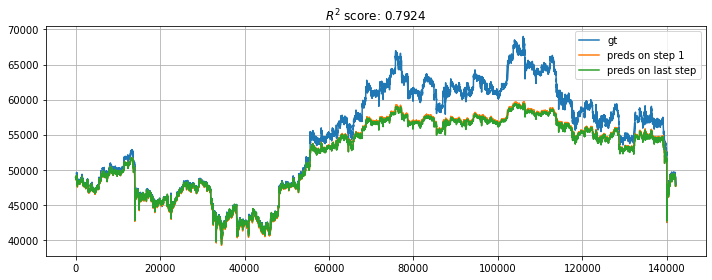

Epoch 7/20
10780/10780 [==============================] - 76s 7ms/step - loss: 4.3613e-05 - val_loss: 0.0023


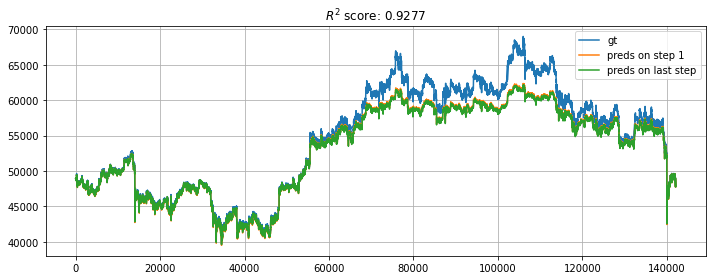

Epoch 8/20
10780/10780 [==============================] - 77s 7ms/step - loss: 2.9848e-05 - val_loss: 0.0017


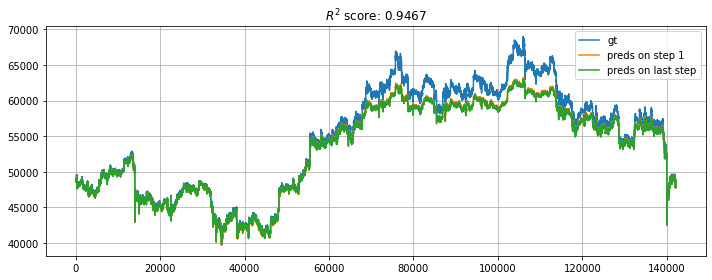

Epoch 9/20
10780/10780 [==============================] - 76s 7ms/step - loss: 2.5701e-05 - val_loss: 0.0015


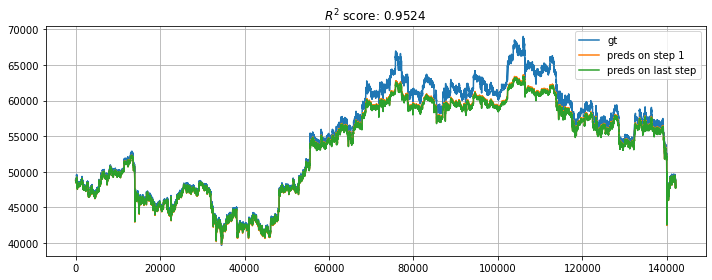

Epoch 10/20
10780/10780 [==============================] - 77s 7ms/step - loss: 2.3290e-05 - val_loss: 0.0013


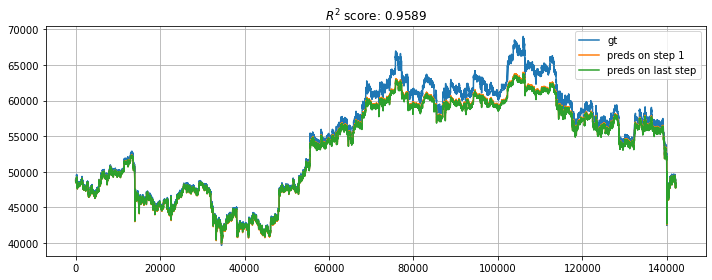

Epoch 11/20
10780/10780 [==============================] - 77s 7ms/step - loss: 2.2026e-05 - val_loss: 0.0012


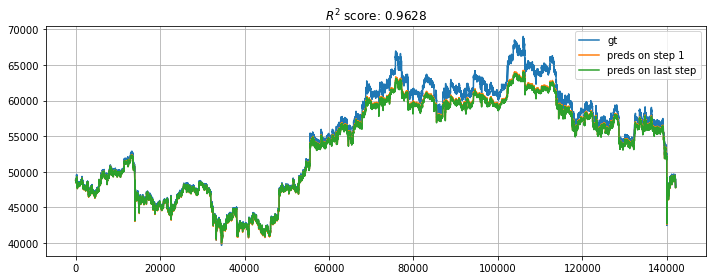

Epoch 12/20
10780/10780 [==============================] - 78s 7ms/step - loss: 2.1096e-05 - val_loss: 9.7916e-04


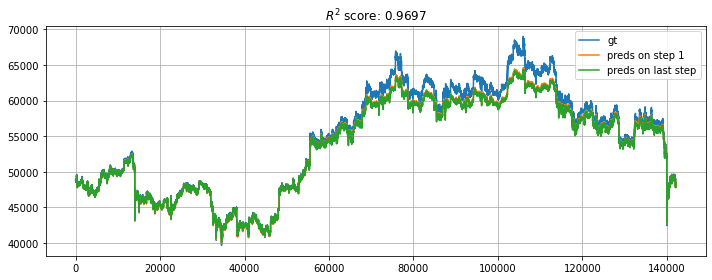

Epoch 13/20
10780/10780 [==============================] - 81s 8ms/step - loss: 2.0099e-05 - val_loss: 8.4812e-04


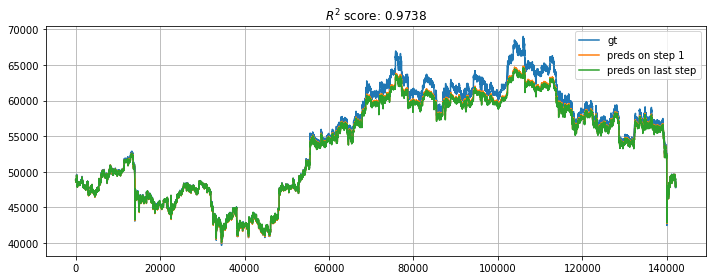

Epoch 14/20
10780/10780 [==============================] - 76s 7ms/step - loss: 1.9573e-05 - val_loss: 7.5498e-04


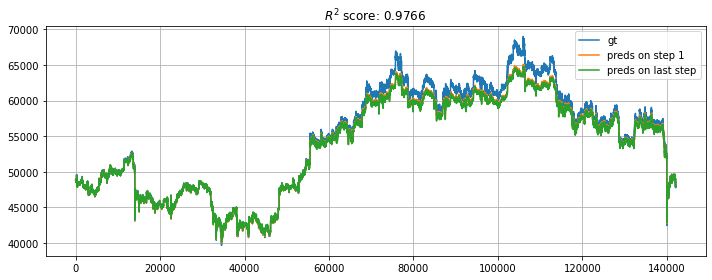

Epoch 15/20
10780/10780 [==============================] - 78s 7ms/step - loss: 1.9156e-05 - val_loss: 6.9645e-04


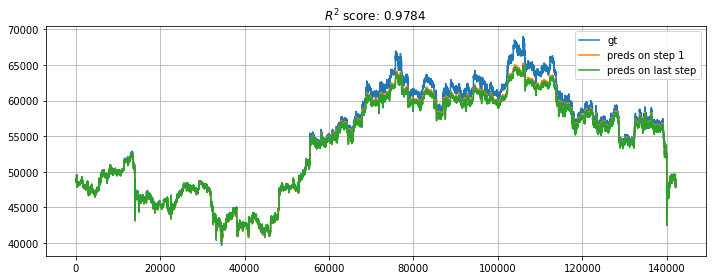

Epoch 16/20
10780/10780 [==============================] - 76s 7ms/step - loss: 1.9007e-05 - val_loss: 6.1494e-04


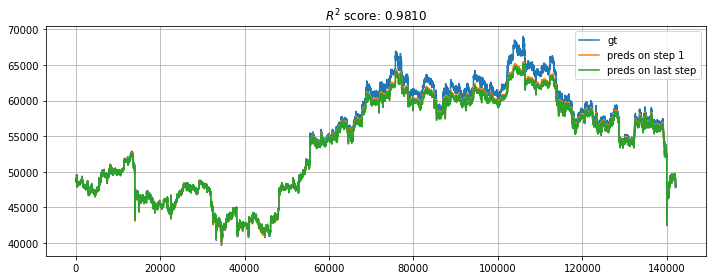

Epoch 17/20
10780/10780 [==============================] - 77s 7ms/step - loss: 1.8672e-05 - val_loss: 5.7212e-04


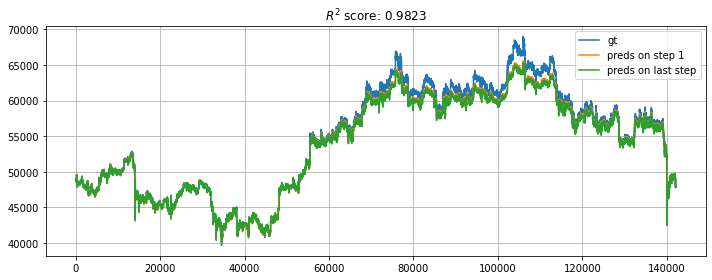

Epoch 18/20
10780/10780 [==============================] - 77s 7ms/step - loss: 1.8573e-05 - val_loss: 5.4234e-04


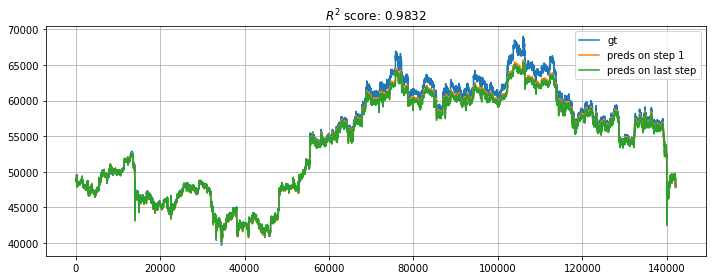

Epoch 19/20
10780/10780 [==============================] - 77s 7ms/step - loss: 1.8364e-05 - val_loss: 4.4685e-04


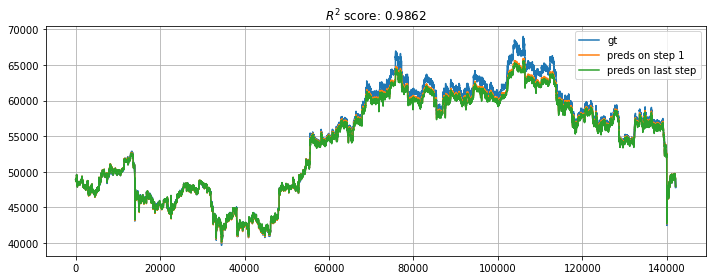

Epoch 20/20
10780/10780 [==============================] - 78s 7ms/step - loss: 1.8173e-05 - val_loss: 3.8418e-04


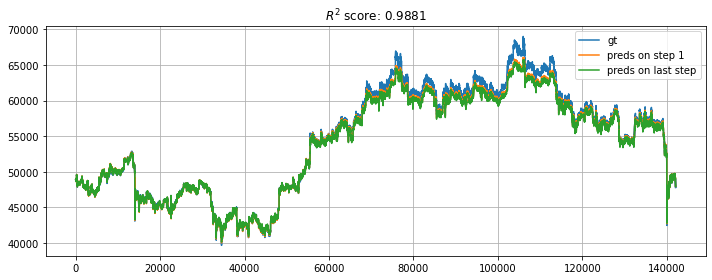

In [25]:
model.compile(optimizer="adam", loss="mse")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_predictions),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=callbacks, verbose=1)

**Single GRU**

In [ ]:
# LSTM models: single, double, autoencoder, bidirectional

hour_inputs = layers.Input(shape=(1,), name="hour")
days_inputs = layers.Input(shape=(1,), name="days")
num_inputs = layers.Input(shape=x_train.shape[-2:], name="number")

x_hour = layers.Embedding(24, 2)(hour_inputs)
x_days = layers.Embedding(367, 3)(days_inputs)

x_hour = layers.Flatten()(x_hour)
x_days = layers.Flatten()(x_days)

x = layers.GRU(64, return_sequences=False)(num_inputs)
x = layers.Concatenate(axis=-1)([x, x_hour, x_days])
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(horizon)(x)

model = tf.keras.Model(inputs=[hour_inputs, days_inputs, num_inputs], outputs=x, name="gru_model")
model.summary()

In [ ]:
model.compile(optimizer="adam", loss="mse")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_predictions),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=callbacks, verbose=1)

**Double LSTM**

In [27]:
hour_inputs = layers.Input(shape=(1,), name="hour")
days_inputs = layers.Input(shape=(1,), name="days")
num_inputs = layers.Input(shape=x_train.shape[-2:], name="number")

x_hour = layers.Embedding(24, 2)(hour_inputs)
x_days = layers.Embedding(367, 3)(days_inputs)

x_hour = layers.Flatten()(x_hour)
x_days = layers.Flatten()(x_days)

seq = tf.keras.Sequential([
       layers.LSTM(128, return_sequences=True, input_shape=x_train.shape[-2:]),
       layers.LSTM(64),
])
x = seq(num_inputs)
x = layers.Concatenate(axis=-1)([x, x_hour, x_days])
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(horizon)(x)

model = tf.keras.Model(inputs=[hour_inputs, days_inputs, num_inputs], outputs=x, name="double_lstm")
model.summary()

Model: "lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hour (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
days (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
number (InputLayer)             [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 2)         48          hour[0][0]                       
_________________________________________________________________________________________

In [ ]:
model.compile(optimizer="adam", loss="mse")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_predictions),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=callbacks, verbose=1)

**Double bidirectional LSTM**

In [30]:
hour_inputs = layers.Input(shape=(1,), name="hour")
days_inputs = layers.Input(shape=(1,), name="days")
num_inputs = layers.Input(shape=x_train.shape[-2:], name="number")

x_hour = layers.Embedding(24, 2)(hour_inputs)
x_days = layers.Embedding(367, 3)(days_inputs)

x_hour = layers.Flatten()(x_hour)
x_days = layers.Flatten()(x_days)

seq = tf.keras.Sequential([
       layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=x_train.shape[-2:]),
       layers.Bidirectional(layers.LSTM(32)),
])
x = seq(num_inputs)
x = layers.Concatenate(axis=-1)([x, x_hour, x_days])
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(horizon)(x)

model = tf.keras.Model(inputs=[hour_inputs, days_inputs, num_inputs], outputs=x, name="bimodel")
model.summary()

Model: "lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hour (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
days (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
number (InputLayer)             [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 2)         48          hour[0][0]                       
_________________________________________________________________________________________

In [ ]:
model.compile(optimizer="adam", loss="mse")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_predictions),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=callbacks, verbose=1)

**AutoEncoder**

In [33]:
hour_inputs = layers.Input(shape=(1,), name="hour")
days_inputs = layers.Input(shape=(1,), name="days")
num_inputs = layers.Input(shape=x_train.shape[-2:], name="number")

x_hour = layers.Embedding(24, 2)(hour_inputs)
x_days = layers.Embedding(367, 3)(days_inputs)

x_hour = layers.Flatten()(x_hour)
x_days = layers.Flatten()(x_days)

seq = tf.keras.Sequential([
       layers.LSTM(128, input_shape=x_train.shape[-2:], return_sequences=True),  # very complex: remove second LSTM layer
       layers.LSTM(64, return_sequences=False),
       layers.RepeatVector(y_train.shape[1]),
       layers.LSTM(128, return_sequences=True),
       layers.LSTM(64, return_sequences=False),
])
x = seq(num_inputs)
x = layers.Concatenate(axis=-1)([x, x_hour, x_days])
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(horizon)(x)

model = tf.keras.Model(inputs=[hour_inputs, days_inputs, num_inputs], outputs=x, name="autoencoder")
model.summary()

Model: "lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hour (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
days (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
number (InputLayer)             [(None, 60, 5)]      0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1, 2)         48          hour[0][0]                       
_________________________________________________________________________________________

In [ ]:
model.compile(optimizer="adam", loss="mse")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_predictions),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=callbacks, verbose=1)

**Transformer**

In [18]:
del x_train, x_test, y_train, y_test, train_data, test_data, x_train_hour, x_test_hour, x_train_day, x_test_day, model; gc.collect()

10971

In [11]:
history_window = 120

x_train, y_train = custom_ts_multi_data_prep(x_scaled, y_scaled, 0, train_split, history_window, horizon)
x_test, y_test = custom_ts_multi_data_prep(x_scaled, y_scaled, train_split, None, history_window, horizon)

x_train_hour = ts["hour"].iloc[history_window:train_split].values.reshape(-1,1)
x_test_hour = ts["hour"].iloc[train_split+history_window:-horizon].values.reshape(-1,1)

x_train_day = ts["day"].iloc[history_window:train_split].values.reshape(-1,1)
x_test_day = ts["day"].iloc[train_split+history_window:-horizon].values.reshape(-1,1)

train_data = tf.data.Dataset.from_tensor_slices(({"hour": x_train_hour, "days": x_train_day, "number": x_train}, y_train)).cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices(({"hour": x_test_hour, "days": x_test_day, "number": x_test}, y_test)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

100%|██████████| 142037/142037 [00:03<00:00, 45445.38it/s]
2022-10-30 21:16:38.615358: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1655424000 exceeds 10% of free system memory.
2022-10-30 21:16:40.444636: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1655424000 exceeds 10% of free system memory.


In [17]:
# Transformer models (encoder: MHA -> Add&Norm -> FFN -> Add&Norm)
class PositionalEmbedding(layers.Layer):
    def __init__(self, history_window, output_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.pos_embed = layers.Embedding(history_window, output_dim)
        self.history_window = history_window
        self.output_dim = output_dim
        
    def call(self, inputs):
        # simple learnable positions (originally cos/sin positions)
        seq_length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=seq_length, delta=1)
        embed_positions = self.pos_embed(positions)
        return inputs + embed_positions
    
    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

def transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=5, dropout=0.35, conv=True):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)  # optional
    
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, inputs])
    res = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Net (conv or dense layers)
    if conv:
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="gelu")(res)  # during training relu was used
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    else:
        x = layers.Dense(ff_dim, activation="gelu")(res)  # relu
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(inputs.shape[-1])(x)
        
    x = layers.Add()([x, res])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

In [25]:
num_transformer_blocks = 4
position = True
order = "channels_first" if not position else "channels_last"

In [29]:
hour_inputs = layers.Input(shape=(1,), name="hour")
days_inputs = layers.Input(shape=(1,), name="days")
num_inputs = layers.Input(shape=x_train.shape[-2:], name="number")

x_hour = layers.Embedding(24, 2)(hour_inputs)
x_days = layers.Embedding(367, 3)(days_inputs)

x_hour = layers.Flatten()(x_hour)
x_days = layers.Flatten()(x_days)

if position:
    pos_size, embed_size = x_train.shape[1], x_train.shape[2]
    x = PositionalEmbedding(pos_size, embed_size)(num_inputs)
else:
    x = num_inputs
    
for _ in range(num_transformer_blocks):
    x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=5, dropout=0.35, conv=True)
print(tf.shape(x))
x = layers.GlobalAveragePooling1D(data_format=order)(x)
# x = layers.TimeDistributed(layers.Dense(10))

x = layers.Concatenate(axis=-1)([x, x_hour, x_days])
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(horizon)(x)

model = tf.keras.Model(inputs=[hour_inputs, days_inputs, num_inputs], outputs=x, name="tranformer")
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 120, 5], name='tf.compat.v1.shape_3/Shape:0', description="created by layer 'tf.compat.v1.shape_3'")
Model: "tranformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
number (InputLayer)             [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
positional_embedding_11 (Positi (None, 120, 5)       600         number[0][0]                     
__________________________________________________________________________________________________
layer_normalization_156 (LayerN (None, 120, 5)       10          positional_embedding_11[0][0]    
___________________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_predictions),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ]

history = model.fit(train_data, epochs=20, validation_data=test_data, callbacks=callbacks, verbose=1)

In [20]:
gc.collect()

769